<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/StableVideoDiffusionCustom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Video Diffusion

This notebook implements [huggingface's implementation](https://huggingface.co/docs/diffusers/using-diffusers/svd) of [Stability AI's](https://arxiv.org/pdf/2311.15127.pdf) Stable Video Diffusion (SVD) Model (woah that was a mouthfull 🥵).

SVD is very similar to Stable Diffusion in many respects except for some major **key** differences:
1.   The UNet in SVD has a **temporal** component added to it
2.   The pretrained text-to-video base model (e.g., SD) is trained on videos

As the authors of [Stability AI](https://arxiv.org/pdf/2311.15127.pdf) state:


>  In this work, we follow the architecture proposed in [Blattmann et al](https://arxiv.org/pdf/2304.08818.pdf) and insert **temporal convolution and attention layers after every spatial convolution and attention layer**[which I will detail later]...[i]n particular, these regimes consist of **Stage I: image pretraining, i.e. a 2D text-to-image diffusion model**...**Stage II: video pretraining, which trains on large amounts of videos**...**Stage III: video finetuning, which refines the model on a small subset of high-quality videos at higher resolution**.

## Stage I: image pretraining

As the authors of [Stability AI](https://arxiv.org/pdf/2311.15127.pdf) state:

> [W]e start the publicly available Stable Diffusion 2.1, where in this work we follow the [EDM-preconditioning framework](https://arxiv.org/pdf/2206.00364.pdf), parameterizing the learnable denoiser $D_{θ}$ as $D_{Θ}(x; σ)= c_{skip}(σ)x+c_{out}(σ)F_{Θ}(c_{in}(σ)x;c_{noise}(σ)), where F_{\theta}$ is the network to be trained...we replace the preconditioning functions with $c_{skip}(σ)=(σ^{2}+1)^{-1}, c_{out}(σ)=\frac{-σ}{\sqrt{σ^2+1}}, c_{in}(σ)=\frac{1}{\sqrt{σ^2+1}}, c_{noise}(σ)=0.25logσ$

> [W]e then finetune the neural network backbone $F_Θ$ of SD 2.1 for 31k iterations using this setup. For the first 1k iterations, we freeze all parameters of $F_θ$ except for the time-embedding layer and train on SD2.1s original training resolution of 512 x 512. This allows the model to adapt to the new preconditioning functions without unnecessarily modifying the internal representations of $F_θ$ too much. Afterward, we train all layers of $F_θ$  for another 30k iterations on images of size 256 x 384, which is the resolution used in the initial stage of video pretraining

## Stage II: video pretraining

As the authors of [Stability AI](https://arxiv.org/pdf/2311.15127.pdf) state:

> After doing image pretraining, the resulting model was used as the image backbone of our video model. After inserting temporal convolutional and attention layers, we then train the model on LVD-F [i.e. the large video dataset filtered to 152 training examples] on 14 frames at a resolution of 256 x 384 for 150k iters. We train the model for classifier-free guidance and drop out the text-conditioning 15% of the time. Afterward, we increase the spatial resolution to 320 x 576 and train for an additional 100k iterations, using the same settings as for the lower-resolution training except for a reduced batch size of 768 and a shift of the noise distribution towards more noise

## Stage III: video finetuning

As the authors of [Stability AI](https://arxiv.org/pdf/2311.15127.pdf) state:

>  [W]e finetune our base model for image-to-video generation, where the video model receives a still input image as a conditioning. Accordingly, we replace text embeddings that are fed into the base model with the CLIP image embedding of the conditioning. Additionally, we concatenate a noise-augmented version
of the conditioning frame channel-wise to the input of the UNet







In [ ]:
!pip install -q -U diffusers transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 32.0 MB/s eta 0:00:00


In [ ]:
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [ ]:
import torch
from diffusers import StableVideoDiffusionPipeline, AutoPipelineForText2Image
from IPython.display import Image as IImage
import gc
from PIL import Image

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
#pipeline = AutoPipelineForText2Image.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16").to("cuda")
pipe = StableVideoDiffusionPipeline.from_pretrained("stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16").to("cuda")
pipe.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/496 [00:00<?, ?B/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/984 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/3.05G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/196M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

image_encoder/config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

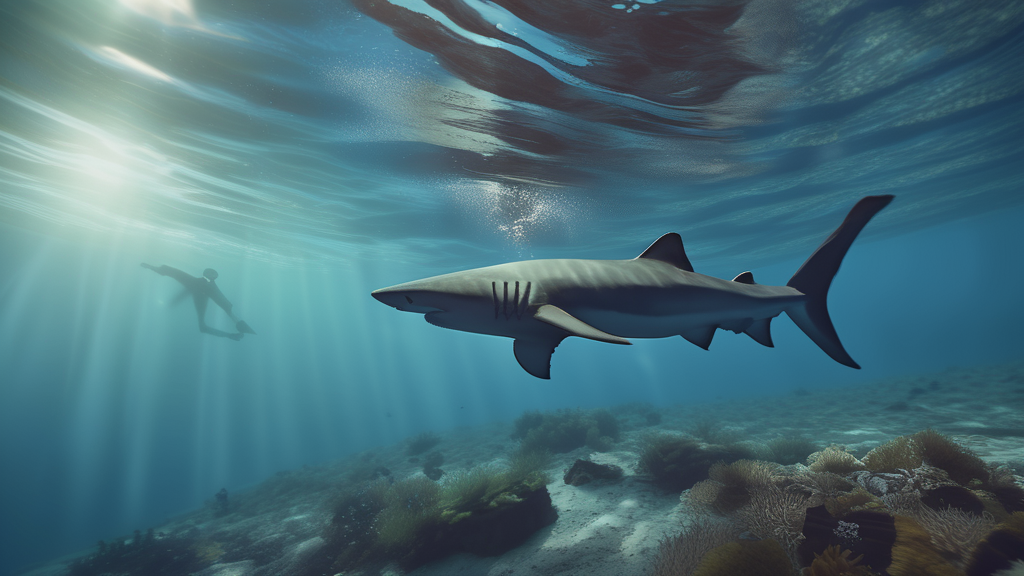

In [ ]:
# generator = torch.Generator("cuda").manual_seed(31)
# image = pipeline("suba diver swimming in ocean next to sharks, detailed, photo-realistic, 8k", height=576, width=1024, generator=generator,num_inference_steps=100).images[0]
# #empty cuda cache with manual garbage collection
# del pipeline
# torch.cuda.empty_cache()
# gc.collect()
# image = image.resize((1024, 576))
# image.save("image.png")

In [ ]:
image=Image.open("/content/download (13).png").convert('RGB')
image_two = image.resize((1024, 576))

  0%|          | 0/25 [00:00<?, ?it/s]

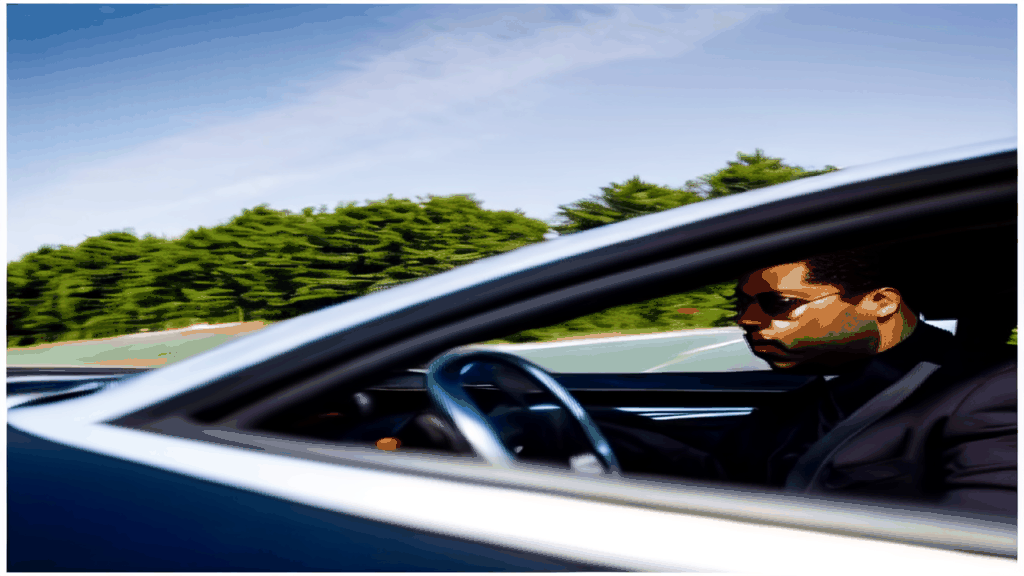

In [ ]:
norm = False
def export_as_gif(filename, images, frames_per_second=7, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )
# turn image into 4 second video
motion = 100 # default is 127, Used as conditioning for the generation. The higher the number the more motion will be in the video.
augmentation = 0.02 # default is 0.02, the amount of noise added to the init image, the higher it is the less the video will look like the init image. Increase it for more motion.
generator = torch.manual_seed(42)
if norm == True:
  pre_generated_lat = torch.normal(0, 1, size=(1, 25, 4, 72, 128), generator=generator, dtype=torch.float16)
else:
  pre_generated_lat = None
frames = pipe(image_two, decode_chunk_size=8, motion_bucket_id=motion, noise_aug_strength=augmentation, latents=pre_generated_lat).frames[0]
export_as_gif("stuff.gif", frames)
torch.cuda.empty_cache()
gc.collect()
IImage("stuff.gif")